In [1]:
import torch as th
import numpy as np
import random

#сделаем инициализацию random seed,
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [3]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 375550658.90it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16057223.47it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70864625.50it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10589510.15it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [7]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

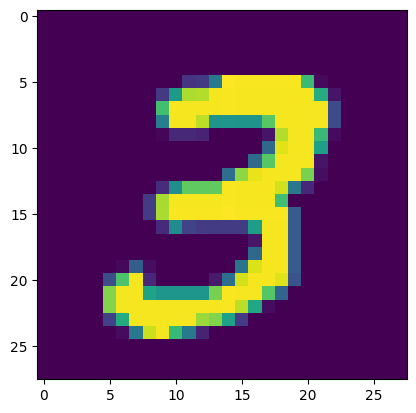

tensor(3)


In [8]:
#посмотрим на картинки
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

In [15]:
#у нас трезмерный тензор, мы хотим двумерный тензор,
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)
X_train.shape

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


torch.Size([60000, 784])

In [84]:
#Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(th.nn.Module):
  def __init__(self, count_col, n):
    super (MNISTnet, self).__init__()
    #слои
    self.fc1 = th.nn.Linear(count_col, n)
    self.act1 = th.nn.Tanh()
    self.fc2 = th.nn.Linear(n, n)
    self.act2 = th.nn.Tanh()
    self.out = th.nn.Linear(n, 10)
    self.sm = th.nn.Softmax(dim=1)



  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.out(x)
    return x



  def predict(self,x):
    with th.no_grad():
      x = self.forward(x)
      x = self.sm(x)
      return x


In [10]:
#есть ли видеокарта?
th.cuda.is_available()

True

In [12]:
!nvidia-smi

Sat Feb 17 13:43:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [79]:
net = MNISTnet(784, 10)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr = 0.001)

batch_size = 50
epochs = 40
for epoch in range(epochs):
  correct_total = 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    opt.zero_grad()
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    X_batch=X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    y_pred = preds.max(1)[1]
    correct_total += (y_pred == y_batch).float().sum().item()
  epoch_accuracy = correct_total / 60000
  print(f"Epoch: {epoch}, Accuracy: {epoch_accuracy}")

Epoch: 0, Accuracy: 0.5801166666666666
Epoch: 1, Accuracy: 0.7188333333333333
Epoch: 2, Accuracy: 0.77065
Epoch: 3, Accuracy: 0.7861333333333334
Epoch: 4, Accuracy: 0.7881333333333334
Epoch: 5, Accuracy: 0.8043166666666667
Epoch: 6, Accuracy: 0.82485
Epoch: 7, Accuracy: 0.8203833333333334
Epoch: 8, Accuracy: 0.8218
Epoch: 9, Accuracy: 0.8182333333333334
Epoch: 10, Accuracy: 0.81675
Epoch: 11, Accuracy: 0.8357666666666667
Epoch: 12, Accuracy: 0.83265
Epoch: 13, Accuracy: 0.8351833333333334
Epoch: 14, Accuracy: 0.8362666666666667
Epoch: 15, Accuracy: 0.8362333333333334
Epoch: 16, Accuracy: 0.84665
Epoch: 17, Accuracy: 0.8468
Epoch: 18, Accuracy: 0.84595
Epoch: 19, Accuracy: 0.8516666666666667
Epoch: 20, Accuracy: 0.8498333333333333
Epoch: 21, Accuracy: 0.8533166666666666
Epoch: 22, Accuracy: 0.8465
Epoch: 23, Accuracy: 0.8478666666666667
Epoch: 24, Accuracy: 0.84535
Epoch: 25, Accuracy: 0.8371666666666666
Epoch: 26, Accuracy: 0.8531166666666666
Epoch: 27, Accuracy: 0.8511833333333333
Epo

###Задание


1.   Дописать код после фразы Ваш_Код_Здесь.
2.   Поэкспериментировать с гиперпараметрами нейронной сети, чтобы добиться более высокой точности классификации.
4.   Построить на одном графике loss для тестовой выборки и для обучающей.
5.   Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
7.   Показать результат работы модели с использованием функции predict (необходимо написать функцию predict).


1 решено выше

2 - попробуем увеличить learning rate для Adam

In [78]:
net = MNISTnet(784, 10)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr = 0.01)

batch_size = 50
epochs = 40
for epoch in range(epochs):
  correct_total = 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    opt.zero_grad()
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    X_batch=X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    y_pred = preds.max(1)[1]
    correct_total += (y_pred == y_batch).float().sum().item()
  epoch_accuracy = correct_total / 60000
  print(f"Epoch: {epoch}, Accuracy: {epoch_accuracy}")

Epoch: 0, Accuracy: 0.26261666666666666
Epoch: 1, Accuracy: 0.3768
Epoch: 2, Accuracy: 0.44371666666666665
Epoch: 3, Accuracy: 0.4583333333333333
Epoch: 4, Accuracy: 0.4381833333333333
Epoch: 5, Accuracy: 0.3596
Epoch: 6, Accuracy: 0.45121666666666665
Epoch: 7, Accuracy: 0.40723333333333334
Epoch: 8, Accuracy: 0.4055666666666667
Epoch: 9, Accuracy: 0.45781666666666665
Epoch: 10, Accuracy: 0.46718333333333334
Epoch: 11, Accuracy: 0.5211166666666667
Epoch: 12, Accuracy: 0.49055
Epoch: 13, Accuracy: 0.40513333333333335
Epoch: 14, Accuracy: 0.5182166666666667
Epoch: 15, Accuracy: 0.52435
Epoch: 16, Accuracy: 0.46221666666666666
Epoch: 17, Accuracy: 0.4354166666666667
Epoch: 18, Accuracy: 0.52385
Epoch: 19, Accuracy: 0.5147166666666667
Epoch: 20, Accuracy: 0.51375
Epoch: 21, Accuracy: 0.5032
Epoch: 22, Accuracy: 0.47935
Epoch: 23, Accuracy: 0.49178333333333335
Epoch: 24, Accuracy: 0.50275
Epoch: 25, Accuracy: 0.5021833333333333
Epoch: 26, Accuracy: 0.47576666666666667
Epoch: 27, Accuracy: 0

Точность сильно упала при увеличении learning rate.
Попробуем уменьшить

In [80]:
net = MNISTnet(784, 10)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr = 0.0005)

batch_size = 50
epochs = 40
for epoch in range(epochs):
  correct_total = 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    opt.zero_grad()
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    X_batch=X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    y_pred = preds.max(1)[1]
    correct_total += (y_pred == y_batch).float().sum().item()
  epoch_accuracy = correct_total / 60000
  print(f"Epoch: {epoch}, Accuracy: {epoch_accuracy}")

Epoch: 0, Accuracy: 0.6464833333333333
Epoch: 1, Accuracy: 0.7818
Epoch: 2, Accuracy: 0.8061666666666667
Epoch: 3, Accuracy: 0.8168666666666666
Epoch: 4, Accuracy: 0.8248333333333333
Epoch: 5, Accuracy: 0.8325166666666667
Epoch: 6, Accuracy: 0.8397333333333333
Epoch: 7, Accuracy: 0.8405
Epoch: 8, Accuracy: 0.8401
Epoch: 9, Accuracy: 0.84965
Epoch: 10, Accuracy: 0.85265
Epoch: 11, Accuracy: 0.8568833333333333
Epoch: 12, Accuracy: 0.8573833333333334
Epoch: 13, Accuracy: 0.8539833333333333
Epoch: 14, Accuracy: 0.8590666666666666
Epoch: 15, Accuracy: 0.8593166666666666
Epoch: 16, Accuracy: 0.8681666666666666
Epoch: 17, Accuracy: 0.87065
Epoch: 18, Accuracy: 0.8654833333333334
Epoch: 19, Accuracy: 0.8673166666666666
Epoch: 20, Accuracy: 0.8723
Epoch: 21, Accuracy: 0.8648833333333333
Epoch: 22, Accuracy: 0.8767833333333334
Epoch: 23, Accuracy: 0.87355
Epoch: 24, Accuracy: 0.8723666666666666
Epoch: 25, Accuracy: 0.8744666666666666
Epoch: 26, Accuracy: 0.88035
Epoch: 27, Accuracy: 0.8792666666

Точность сети возросла

Попробуем увеличить размер одного пакета в дополнение к уменьшению learning rate

In [81]:
net = MNISTnet(784, 10)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr = 0.0005)

batch_size = 100
epochs = 40
for epoch in range(epochs):
  correct_total = 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    opt.zero_grad()
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    X_batch=X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    y_pred = preds.max(1)[1]
    correct_total += (y_pred == y_batch).float().sum().item()
  epoch_accuracy = correct_total / 60000
  print(f"Epoch: {epoch}, Accuracy: {epoch_accuracy}")

Epoch: 0, Accuracy: 0.6318
Epoch: 1, Accuracy: 0.7813833333333333
Epoch: 2, Accuracy: 0.8086833333333333
Epoch: 3, Accuracy: 0.8359166666666666
Epoch: 4, Accuracy: 0.8376833333333333
Epoch: 5, Accuracy: 0.8449166666666666
Epoch: 6, Accuracy: 0.8518666666666667
Epoch: 7, Accuracy: 0.85185
Epoch: 8, Accuracy: 0.8550333333333333
Epoch: 9, Accuracy: 0.8577833333333333
Epoch: 10, Accuracy: 0.8578833333333333
Epoch: 11, Accuracy: 0.865
Epoch: 12, Accuracy: 0.8668166666666667
Epoch: 13, Accuracy: 0.8654333333333334
Epoch: 14, Accuracy: 0.875
Epoch: 15, Accuracy: 0.8737166666666667
Epoch: 16, Accuracy: 0.8744333333333333
Epoch: 17, Accuracy: 0.87805
Epoch: 18, Accuracy: 0.87765
Epoch: 19, Accuracy: 0.8797333333333334
Epoch: 20, Accuracy: 0.8837333333333334
Epoch: 21, Accuracy: 0.8806
Epoch: 22, Accuracy: 0.8770333333333333
Epoch: 23, Accuracy: 0.8830833333333333
Epoch: 24, Accuracy: 0.8799833333333333
Epoch: 25, Accuracy: 0.8842833333333333
Epoch: 26, Accuracy: 0.88525
Epoch: 27, Accuracy: 0.8

Точность близка к предыдущему примеру

3 - loss на обучающей и тестовой выборке

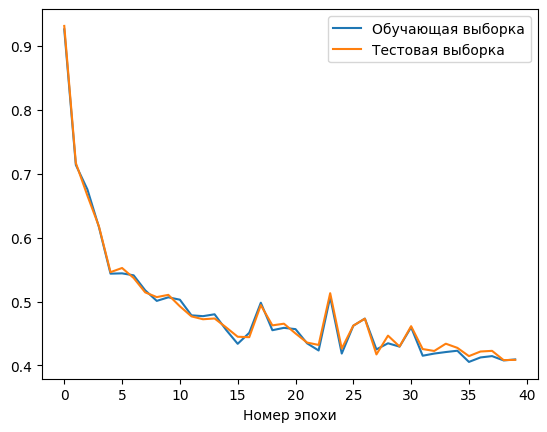

In [93]:
net = MNISTnet(784, 10)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr = 0.0005)
train_list = []
test_list = []
batch_size = 50
epochs = 40
for epoch in range(epochs):
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    opt.zero_grad()
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    X_batch=X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
  with th.no_grad():
    x = X_train.to(device)
    y = y_train.to(device)
    preds = net.forward(x)
    loss_val = loss(preds, y)
    train_list.append(loss_val.item())

    x = X_test.to(device)
    y = y_test.to(device)
    preds = net.forward(x)
    loss_val = loss(preds, y)
    test_list.append(loss_val.item())

plt.plot(train_list, label="Обучающая выборка")
plt.plot(test_list, label="Тестовая выборка")
plt.xlabel('Номер эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()



4 - Увеличим количество эпох

Попробуем улучшить работу сети с learning rate 0.01 путём добавления большего количества эпох

In [96]:
net = MNISTnet(784, 10)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr = 0.01)

batch_size = 50
epochs = 200
for epoch in range(epochs):
  correct_total = 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    opt.zero_grad()
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    X_batch=X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    y_pred = preds.max(1)[1]
    correct_total += (y_pred == y_batch).float().sum().item()
  epoch_accuracy = correct_total / 60000
  print(f"Epoch: {epoch}, Accuracy: {epoch_accuracy}")

Epoch: 0, Accuracy: 0.23148333333333335
Epoch: 1, Accuracy: 0.30035
Epoch: 2, Accuracy: 0.34126666666666666
Epoch: 3, Accuracy: 0.33775
Epoch: 4, Accuracy: 0.3713
Epoch: 5, Accuracy: 0.38556666666666667
Epoch: 6, Accuracy: 0.38948333333333335
Epoch: 7, Accuracy: 0.4014333333333333
Epoch: 8, Accuracy: 0.39458333333333334
Epoch: 9, Accuracy: 0.41378333333333334
Epoch: 10, Accuracy: 0.41125
Epoch: 11, Accuracy: 0.386
Epoch: 12, Accuracy: 0.4027
Epoch: 13, Accuracy: 0.41028333333333333
Epoch: 14, Accuracy: 0.42895
Epoch: 15, Accuracy: 0.4400833333333333
Epoch: 16, Accuracy: 0.4422333333333333
Epoch: 17, Accuracy: 0.4570666666666667
Epoch: 18, Accuracy: 0.45331666666666665
Epoch: 19, Accuracy: 0.44325
Epoch: 20, Accuracy: 0.4552
Epoch: 21, Accuracy: 0.47558333333333336
Epoch: 22, Accuracy: 0.4343666666666667
Epoch: 23, Accuracy: 0.3980166666666667
Epoch: 24, Accuracy: 0.3760833333333333
Epoch: 25, Accuracy: 0.4341
Epoch: 26, Accuracy: 0.50395
Epoch: 27, Accuracy: 0.4977666666666667
Epoch: 2

Увеличение количества эпох не улучшило модель

5 - Тест метода predict

In [97]:
net = MNISTnet(784, 10)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr = 0.0005)

batch_size = 50
epochs = 40
for epoch in range(epochs):
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    opt.zero_grad()
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    X_batch=X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
preds = net.predict(X_test.to(device))

In [106]:
y_pred = preds.max(1)[1]
y_pred

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [109]:
from sklearn.metrics import confusion_matrix

In [114]:
print(confusion_matrix(y_test, y_pred.cpu()))

[[ 932    0    2    1    0    5   30    5    5    0]
 [   0 1091    7    7    1    2    7    4   16    0]
 [  26    4  905   30   13    1   26    9   17    1]
 [   8    5   21  879    1   54    5   14   18    5]
 [   0    3    7    1  902    1   24    5   12   27]
 [  21    4    1   54    6  705   19    3   72    7]
 [   7    2    4    1   23    7  896    0   17    1]
 [   2    8   29   21    9    2    2  938    0   17]
 [  14    5   14   17    5    8   27    6  875    3]
 [   7    3    1   12  105    9    6   35   13  818]]
